___
<img style="float: right; margin: 15px 15px 15px 15px;" src="https://samyzaf.com/ML/cifar10/cifar1.jpg" width="380px" height="180px" />


# <font color= #bbc28d> **Training CNN's - CIFAR NN Models** </font>
#### <font color= #2E9AFE> `Lab 2 - Machine Learning`</font>
- <Strong> Sofía Maldonado, Diana Valdivia, Samantha Sánchez, Isabel Valladolid & Vivienne Toledo </Strong>
- <Strong> Fecha </Strong>: 27/10/2025.

___

<p style="text-align:right;"> Image retrieved from: https://samyzaf.com/ML/cifar10/cifar1.jpg</p>

# <font color= #bbc28d> **Abstract** </font>

The following notebook aims to explore the process of training Convolutional Neural Netowrks (CNN's) with different configurations to evaluate performance, via an image classification of the CIFAR-10 dataset.

----

In [8]:
# === IMPORTS ===

# Generales
import random
import csv
import numpy as np
import pandas as pd

# Redes Neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision.models import alexnet, AlexNet_Weights, vgg16, VGG16_Weights
from torchvision import transforms
from torch.nn.init import kaiming_uniform_, xavier_uniform_, orthogonal_, zeros_

# Visualization
import matplotlib.pyplot as plt

In [2]:
# GPU Usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using Device:", device)

Using Device: cuda


# <font color= #bbc28d> **Data Loading, Visualization and Preprocessing** </font>

In [ ]:
# Data Importing
dataset = torch.load("l2_data/cifar10_subset.pt")

In this notebook, we're going to be using the CIFAR-10 dataset, which contains images belonging to 10 different classes:


|Label| Meaning |
|--|--|
| 0 | airplane |
| 1 | automobile |
| 2 | bird |
| 3 | cat |
| 4 | deer |
| 5 | dog |
| 6 | frog |
| 7 | horse |
| 8 | ship |
| 9 | truck |

In [4]:
label_dict = {
    '0': 'airplane',
    '1': 'automobile',
    '2': 'bird',
    '3': 'cat',
    '4': 'deer',
    '5': 'dog',
    '6': 'frog',
    '7': 'horse',
    '8': 'ship',
    '9': 'truck',
}

These are some of the images available in CIFAR-10:

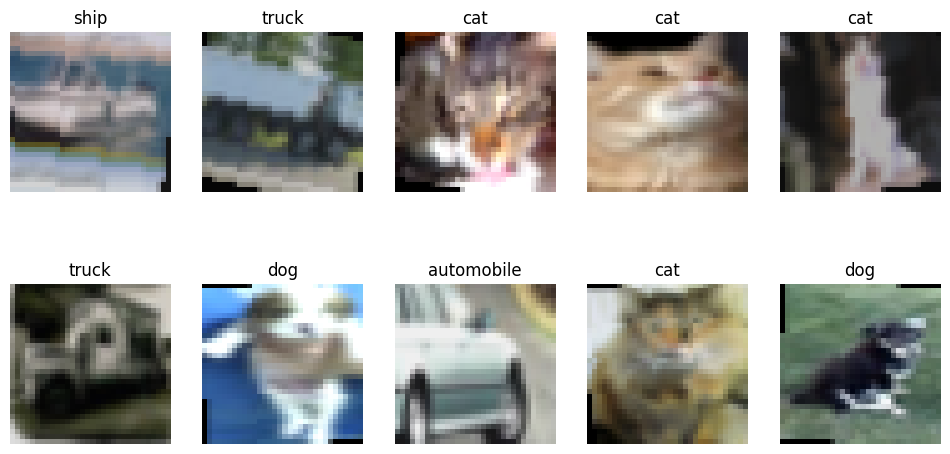

In [ ]:
# Quick image preview
images, labels = dataset

idxs = random.sample(range(len(images)), 10)
sample_images = images[idxs]
sample_labels = labels[idxs]

plt.figure(figsize=(12,6))
for i, (img, label) in enumerate(zip(sample_images, sample_labels)):
    plt.subplot(2,5, i+ 1)
    plt.imshow(img.permute(1,2,0))
    plt.title(label_dict[str(label.item())])
    plt.axis('off')
plt.show()

Now, we proceed to do a train-test-split for modeling:

In [6]:
images = F.interpolate(images, size=(224, 224), mode='bilinear', align_corners=False) # To make images 224x224, a requirement for both AlexNet and VGG16

dataset = TensorDataset(images, labels)
train_size = int(0.8 * len(dataset)) # 80% train
test_size = len(dataset) - train_size #20% test
train_ds, test_ds = torch.utils.data.random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42)) # Same seed so data is always split in the same way

# <font color= #bbc28d> **CNN Configurations** </font>

Since the goal of this notebook is to evaluate the elements involved in training CNN's, not only the architecture of the models, but also the seeds, optimizers, solvers and other hyperparameters of the Neural Networks, we're going to be testing 3 different NN architectures, paired with a combination of hyperparameters, to describe and record the changes in all of the permutations. The selected parameters for the test are the following:

### <font color= #66b0b0> &ensp; **Models** </font>

- AlexNet
- VGG16
- Own Design

### <font color= #66b0b0> &ensp; **Seeds** </font>
- Seed 0
- Seed 42
- Seed 21

### <font color= #66b0b0> &ensp; **Factors & Conditions** </font>

- Optimizers (SGD, Adam, AdamW)
- Regularization (1e-4, 5e-4, 2e-3)
- Batch Size (32, 128, 512)
- Learning-Rate Schedules (StepLR, Cosine, OneCycle)
- Weight Initialization (Kaiming, Xavier, Orthogonal)

This makes up a `total of 135 different Neural Networks`.

In [10]:
OPTIMIZER_OPTIONS = ['Adam','AdamW','SGD'] # SGD must have a momentum of 0.9
REGULARIZATION_OPTIONS = [1e-4, 5e-4, 2e-3]
BATCH_SIZE_OPTIONS = [32, 128, 512]
LR_SCHEDULES_OPTIONS = ['Constant', 'StepLR', 'Cosine']
WEIGHT_INITIALIZATION_OPTIONS = ['Kaiming', 'Xavier', 'Orthogonal']
SEEDS = [0, 42, 21]
# Subject to change

In [7]:
BASELINE = {
    'optimizer': 'SGD',
    'reg': 1e-4,
    'batch': 128,
    'schedule': 'Cosine',
    'init': 'Kaiming'
}

# <font color= #bbc28d> **Modeling** </font>

## <font color= #66b0b0> &ensp; • **AlexNet** </font>

In [9]:
# AlexNet helper functions
def init_weights(model, method):
    for i in model.modules():
        if isinstance(i, nn.Linear):
            if method == 'Kaiming':
                kaiming_uniform_(i.weight, nonlinearity='relu')
            elif method == 'Xavier':
                xavier_uniform_(i.weight)
            elif method == 'Orthogonal':
                orthogonal_(i.weight)
            if i.bias is not None:
                zeros_(i.bias)

# Train - Test Loaders
train_loader = DataLoader(train_ds, )

def build_optimizer(model, name, reg):
    if name == 'Adam':
        return optim.Adam(model.parameters(), lr=1e-4, weight_decay=reg)
    elif name == 'AdamW':
        return optim.AdamW(model.parameters(), lr=1e-4, weight_decay=reg)
    elif name == 'SGD':
        return optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=reg)

def build_scheduler(optimizer, name):
    if name == 'StepLR':
        return optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    elif name == 'Cosine':
        return optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    else:
        return None

def train_eval_alexnet(model, optimizer, scheduler, seed, train_loader, test_loader):
    torch.manual_seed(seed)
    criterion = torch.nn.CrossEntropyLoss()

    epoch_losses = []

    # Training
    for e in range(8):
        model.train()
        running_loss = 0
        for imgs, lbls in train_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, lbls)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * imgs.size(0)

        if scheduler:
            scheduler.step()
        
        avg_loss = running_loss / len(train_loader)
        epoch_losses.append(avg_loss)
    
    final_loss = epoch_losses[-1]
    
    # Evaluation
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for imgs, lbls in test_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(1)
            correct += (preds == lbls).sum().item()
            total += lbls.size(0)
    
    acc = correct / total
    print(f"Epoch {e+1}: Train Loss={avg_loss:.4f}, Val Acc={acc:.4f}")
    return acc, final_loss, epoch_losses

def dummy_test():
    acc = random.random()
    loss = random.random()
    epochs = [(random.randint(1,10), random.randint(1,10)) for i in range(10)]
    

    return acc, loss, epochs

In [ ]:
# Running AlexNet tests

results = []
categories = {
    'optimizer': OPTIMIZER_OPTIONS,
    'reg': REGULARIZATION_OPTIONS,
    'batch': BATCH_SIZE_OPTIONS,
    'schedule': LR_SCHEDULES_OPTIONS,
    'init': WEIGHT_INITIALIZATION_OPTIONS
}

for category, options in categories.items():
    for option in options:
        cfg = BASELINE.copy()
        cfg[category] = option

        for seed in SEEDS:
            # Model building

            train_loader = DataLoader(train_ds, batch_size=cfg['batch'], shuffle=True)
            test_loader = DataLoader(test_ds, batch_size=cfg['batch'])

            alex_model = alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)
            alex_model.classifier[6] = nn.Linear(4096, 10)
            init_weights(alex_model, cfg['init'])
            alex_model.to(device)

            optimizer = build_optimizer(alex_model, cfg['optimizer'], cfg['reg'])
            scheduler = build_scheduler(optimizer, cfg['schedule'])
            acc, final_loss, epoch_losses = train_eval_alexnet(alex_model, optimizer, scheduler, seed, train_loader, test_loader) 
            #acc, loss, epoch_losses = dummy_test()

            results.append((category, option, seed, acc, final_loss, epoch_losses[0], epoch_losses[1],epoch_losses[2], epoch_losses[3],epoch_losses[4], epoch_losses[5],
                            epoch_losses[6], epoch_losses[7]))
            print(f'{category}, {option}. Seed -> {seed}. Acc -> {acc:.3f}')

df = pd.DataFrame(results, columns=['category', 'option', 'seed', 'acc', 'loss','E1','E2','E3','E4','E5','E6','E7','E8'])
df.to_csv('alexnet_logs_FAILSAFE.csv', index=False)

optimizer, Adam. Seed -> 0. Acc -> 0.968
optimizer, Adam. Seed -> 42. Acc -> 0.979
optimizer, Adam. Seed -> 21. Acc -> 0.959
optimizer, AdamW. Seed -> 0. Acc -> 0.971
optimizer, AdamW. Seed -> 42. Acc -> 0.969
optimizer, AdamW. Seed -> 21. Acc -> 0.959
optimizer, SGD. Seed -> 0. Acc -> 0.329
optimizer, SGD. Seed -> 42. Acc -> 0.312
optimizer, SGD. Seed -> 21. Acc -> 0.320
reg, 0.0001. Seed -> 0. Acc -> 0.327
reg, 0.0001. Seed -> 42. Acc -> 0.314
reg, 0.0001. Seed -> 21. Acc -> 0.318
reg, 0.0005. Seed -> 0. Acc -> 0.327
reg, 0.0005. Seed -> 42. Acc -> 0.311
reg, 0.0005. Seed -> 21. Acc -> 0.315
reg, 0.002. Seed -> 0. Acc -> 0.323
reg, 0.002. Seed -> 42. Acc -> 0.308
reg, 0.002. Seed -> 21. Acc -> 0.318
batch, 32. Seed -> 0. Acc -> 0.483
batch, 32. Seed -> 42. Acc -> 0.466
batch, 32. Seed -> 21. Acc -> 0.495
batch, 128. Seed -> 0. Acc -> 0.327
batch, 128. Seed -> 42. Acc -> 0.311
batch, 128. Seed -> 21. Acc -> 0.315
batch, 512. Seed -> 0. Acc -> 0.159
batch, 512. Seed -> 42. Acc -> 0.192

In [7]:
def mean_std_summary(df):
    # Calculate the mean and std by category and option
    summary = df.groupby(['category', 'option'])[['acc', 'loss']].agg(['mean', 'std'])
    summary = summary.reset_index()

    # Format the summary
    summary['acc_mean_std'] = summary['acc']['mean'].round(4).astype(str) + ' ± ' + summary['acc']['std'].round(4).astype(str)
    summary['loss_mean_std'] = summary['loss']['mean'].round(4).astype(str) + ' ± ' + summary['loss']['std'].round(4).astype(str)

    # Keep only the readable columns
    summary = summary[['category', 'option', 'acc_mean_std', 'loss_mean_std']]
    return summary

alexnet_logs = pd.read_csv('alexnet_logs.csv')
mean_std_summary(alexnet_logs)

,category,option,acc_mean_std,loss_mean_std
,,,,
0,batch,128,0.3179 ± 0.0083,277.7821 ± 0.7886
1,batch,32,0.4811 ± 0.0145,52.7425 ± 1.3859
2,batch,512,0.1699 ± 0.0195,1161.6049 ± 2.0414
3,init,Kaiming,0.3197 ± 0.0062,277.8585 ± 0.7354
4,init,Orthogonal,0.3508 ± 0.0357,274.7436 ± 1.4143
5,init,Xavier,0.329 ± 0.0362,274.8996 ± 0.7801
6,optimizer,Adam,0.9687 ± 0.0099,8.7844 ± 1.1967
7,optimizer,AdamW,0.9664 ± 0.0064,9.5085 ± 0.6616
8,optimizer,SGD,0.3202 ± 0.0083,277.8393 ± 0.8106


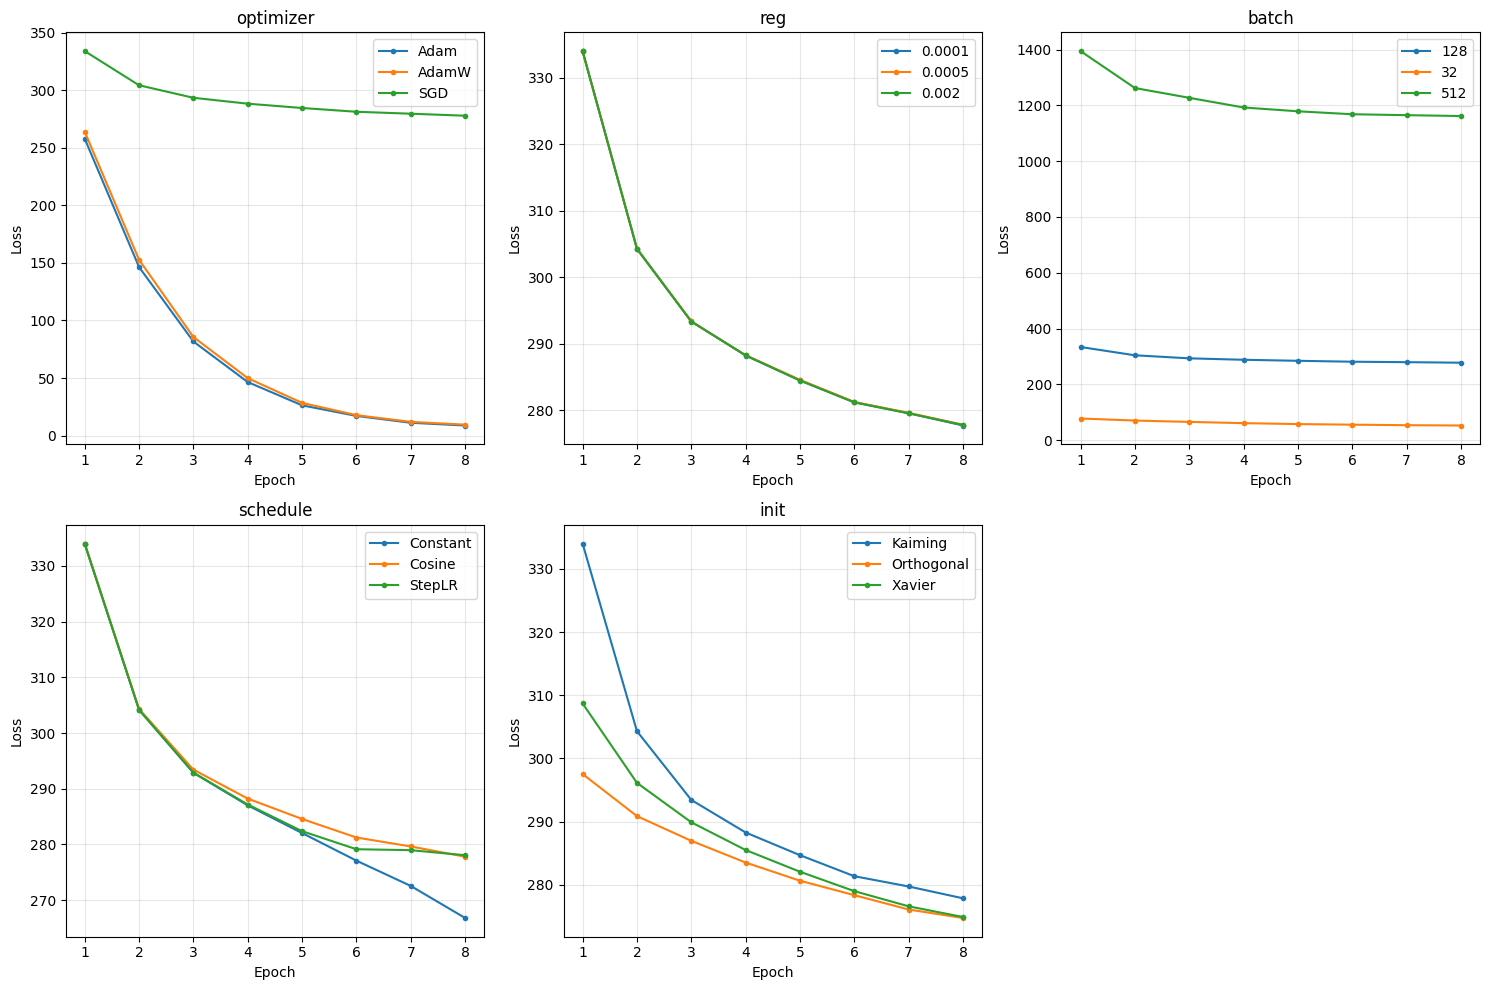

In [24]:
def plot_training_curves(df, figsize=(15, 10)):
    # Reshape data
    epoch_cols = ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8']
    df_long = pd.melt(df, 
                      id_vars=['category', 'option', 'seed'], 
                      value_vars=epoch_cols, 
                      var_name='epoch', 
                      value_name='epoch_loss')
    
    # Convert epochs to integers 
    df_long['epoch'] = df_long['epoch'].str.slice(1).astype(int)
    
    # Calculate mean loss per category, option and epoch
    mean_loss = df_long.groupby(['category', 'option', 'epoch'])['epoch_loss'].mean().reset_index()
    
    # Create subplots for each category
    categories = df['category'].unique()
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    axes = axes.flatten()
    
    for i, category in enumerate(categories):
        if i < len(axes):
            ax = axes[i]
            cat_data = mean_loss[mean_loss['category'] == category]
            
            for option in cat_data['option'].unique():
                option_data = cat_data[cat_data['option'] == option]
                ax.plot(option_data['epoch'], option_data['epoch_loss'], 
                       label=option, marker='o', markersize=3)
            
            ax.set_title(f'{category}')
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Loss')
            ax.legend()
            ax.grid(True, alpha=0.3)
    
    # Remove empty subplots
    for i in range(len(categories), len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

plot_training_curves(alexnet_logs)

**Note: reg values overlap

## <font color= #66b0b0> &ensp; • **VGG16** </font>

Since VGG16 is more computationally expensive than AlexNet, we decided to turn off some of the parameters to test on, leaving us with a total of 27 models for VGG16:

In [9]:
OPTIMIZER_OPTIONS = ['Adam','SGD'] # SGD must have a momentum of 0.9
REGULARIZATION_OPTIONS = [1e-4, 5e-4]
BATCH_SIZE_OPTIONS = [32, 128, 512]
LR_SCHEDULES_OPTIONS = ['Constant', 'Cosine']
SEEDS = [0, 42, 21]

For the same reason, we're only retraining the last fully connected layer with our data:

In [10]:
def init_weights(layer, method):
    if method == 'Kaiming':
        nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
    elif method == 'Xavier':
        nn.init.xavier_uniform_(layer.weight)
    elif method == 'Orthogonal':
        nn.init.orthogonal_(layer.weight)
    if layer.bias is not None:
        nn.init.zeros_(layer.bias)

def build_optimizer(params, name, reg):
    if name == 'Adam':
        return optim.Adam(params, lr=1e-4, weight_decay=reg)
    elif name == 'AdamW':
        return optim.AdamW(params, lr=1e-4, weight_decay=reg)
    elif name == 'SGD':
        return optim.SGD(params, lr=1e-4, momentum=0.9, weight_decay=reg)

def build_scheduler(optimizer, name):
    if name == 'StepLR':
        return optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    elif name == 'Cosine':
        return optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    else:
        return None

def train_eval_model(model, optimizer, scheduler, train_loader, test_loader, epochs=8):
    criterion = nn.CrossEntropyLoss()
    epoch_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * imgs.size(0)

        if scheduler:
            scheduler.step()

        avg_loss = running_loss / len(train_loader.dataset)
        epoch_losses.append(avg_loss)

        # Evaluación
        model.eval()
        correct = total = 0
        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                preds = outputs.argmax(1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        val_acc = correct / total

        # Print por época
        print(f"Epoch {epoch+1}/{epochs}: Train Loss = {avg_loss:.4f}, Val Acc = {val_acc:.4f}")

    final_loss = epoch_losses[-1]
    return val_acc, final_loss, epoch_losses


In [11]:
results = []
categories = {
    'optimizer': OPTIMIZER_OPTIONS,
    'reg': REGULARIZATION_OPTIONS,
    'schedule': LR_SCHEDULES_OPTIONS,
    'init': WEIGHT_INITIALIZATION_OPTIONS
}

for category, options in categories.items():
    for option in options:
        cfg = BASELINE.copy()
        cfg[category] = option

        for seed in SEEDS:
            # Limpiar cache GPU antes de crear nuevo modelo
            torch.cuda.empty_cache()
            torch.manual_seed(seed)

            # DataLoaders
            train_loader = DataLoader(train_ds, batch_size=cfg['batch'], shuffle=True)
            test_loader = DataLoader(test_ds, batch_size=cfg['batch'])

            # Modelo VGG16
            model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
            for param in model.parameters():
                param.requires_grad = False  # congelar todas las capas

            model.classifier[6] = nn.Linear(4096, 10)
            init_weights(model.classifier[6], cfg['init'])
            model.to(device)

            # Optimizer y Scheduler
            optimizer = build_optimizer(model.classifier[6].parameters(), cfg['optimizer'], cfg['reg'])
            scheduler = build_scheduler(optimizer, cfg['schedule'])

            # Entrenar y evaluar
            val_acc, final_loss, epoch_losses = train_eval_model(model, optimizer, scheduler, train_loader, test_loader)

            # Guardar resultados en formato igual que tu CSV original
            results.append([
                category,
                option,
                seed,
                val_acc,
                final_loss,
                epoch_losses[0],
                epoch_losses[1],
                epoch_losses[2],
                epoch_losses[3],
                epoch_losses[4],
                epoch_losses[5],
                epoch_losses[6],
                epoch_losses[7]
            ])
            print(f'{category}, {option}. Seed -> {seed}. Acc -> {val_acc:.3f}')
            del model

# Exportar CSV final
df = pd.DataFrame(results, columns=['category', 'option', 'seed', 'acc', 'loss', 'E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8'])
df.to_csv('vgg16_logs.csv', index=False)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\Vivienne/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [00:30<00:00, 18.0MB/s] 


Epoch 1/8: Train Loss = 2.4189, Val Acc = 0.2553
Epoch 2/8: Train Loss = 2.2386, Val Acc = 0.3364
Epoch 3/8: Train Loss = 2.1116, Val Acc = 0.3712
Epoch 4/8: Train Loss = 2.0006, Val Acc = 0.4114
Epoch 5/8: Train Loss = 1.9642, Val Acc = 0.4250
Epoch 6/8: Train Loss = 1.9073, Val Acc = 0.4424
Epoch 7/8: Train Loss = 1.8755, Val Acc = 0.4417
Epoch 8/8: Train Loss = 1.8806, Val Acc = 0.4477
optimizer, Adam. Seed -> 0. Acc -> 0.448
Epoch 1/8: Train Loss = 2.4904, Val Acc = 0.1856
Epoch 2/8: Train Loss = 2.2615, Val Acc = 0.2970
Epoch 3/8: Train Loss = 2.1440, Val Acc = 0.3712
Epoch 4/8: Train Loss = 2.0444, Val Acc = 0.4008
Epoch 5/8: Train Loss = 1.9767, Val Acc = 0.4205
Epoch 6/8: Train Loss = 1.9160, Val Acc = 0.4326
Epoch 7/8: Train Loss = 1.8869, Val Acc = 0.4477
Epoch 8/8: Train Loss = 1.8779, Val Acc = 0.4508
optimizer, Adam. Seed -> 42. Acc -> 0.451
Epoch 1/8: Train Loss = 2.4512, Val Acc = 0.2083
Epoch 2/8: Train Loss = 2.2506, Val Acc = 0.3280
Epoch 3/8: Train Loss = 2.1212, Val

As we can see by the results achieved, no matter how much we changed the parameters of VGG16, the scores did not improve significantly. This may be due to the fact that only the last layer was re-trained, however, re-training the whole NN would have been incredibly computationally expensive.

In [6]:
vgg16_logs = pd.read_csv('vgg16_logs.csv')
mean_std_summary(vgg16_logs)

,category,option,acc_mean_std,loss_mean_std
,,,,
0,init,Kaiming,0.2722 ± 0.015,2.2635 ± 0.0066
1,init,Orthogonal,0.3121 ± 0.0098,2.1677 ± 0.0117
2,init,Xavier,0.272 ± 0.0146,2.263 ± 0.0066
3,optimizer,Adam,0.4467 ± 0.0046,1.8772 ± 0.0038
4,optimizer,SGD,0.2722 ± 0.015,2.2635 ± 0.0066
5,reg,0.0001,0.2722 ± 0.015,2.2635 ± 0.0066
6,reg,0.0005,0.2722 ± 0.015,2.2635 ± 0.0066
7,schedule,Constant,0.3316 ± 0.0088,2.1793 ± 0.0022
8,schedule,Cosine,0.2722 ± 0.015,2.2635 ± 0.0066


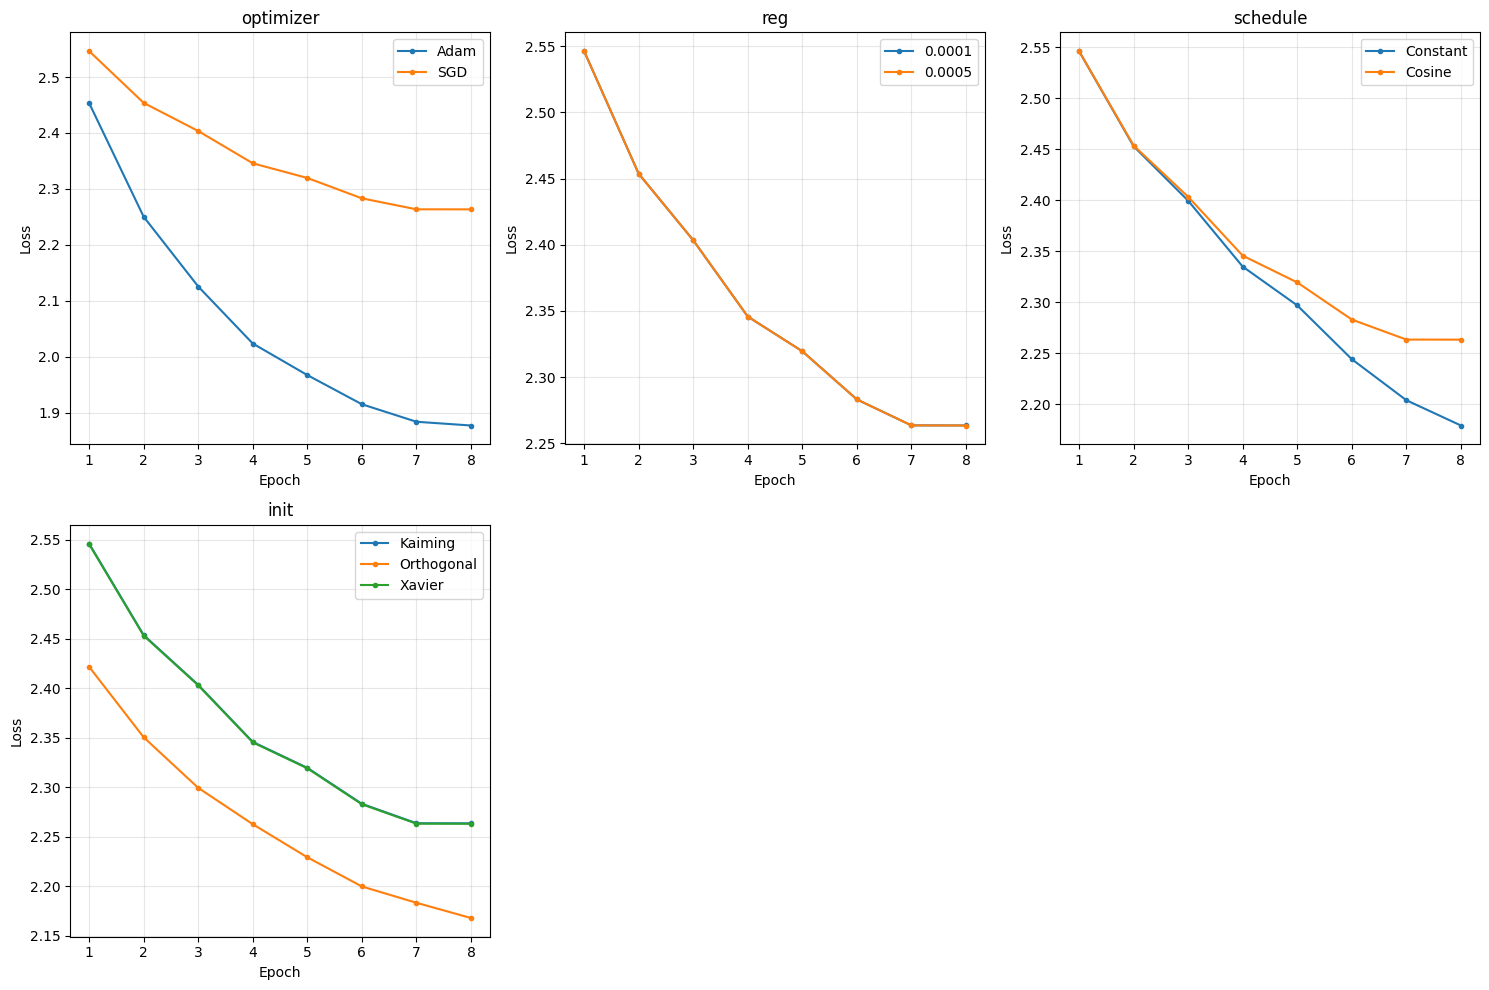

In [25]:
plot_training_curves(vgg16_logs)

**Note: Kaiming and Xavier overlap.

## <font color= #66b0b0> &ensp; • **Own Design** </font>

Taking inspiration from the other models being tested in this notebook, our model builds on their foundations:

| Layer           | Type      | Output Size   | Parameters   |
|----------------|-----------|-------------------|---------------|
| conv1          | Conv2d    | 224×224×32        | 2,432         |
| pool1          | MaxPool2d | 112×112×32        | 0             |
| conv2          | Conv2d    | 112×112×64        | 18,496        |
| pool2          | MaxPool2d | 56×56×64          | 0             |
| conv3          | Conv2d    | 56×56×128         | 73,856        |
| pool3          | MaxPool2d | 28×28×128         | 0             |
| fc1            | Linear    | 512               | 51,389,824    |
| dropout1       | Dropout   | 512               | 0             |
| fc2            | Linear    | 128               | 65,664        |
| dropout2       | Dropout   | 128               | 0             |
| fc3            | Linear    | 10                | 1,290         |

**Total trainable params:** 51,551,562


In [15]:
OPTIMIZER_OPTIONS = ['Adam'] # SGD must have a momentum of 0.9
REGULARIZATION_OPTIONS = [0.0, 0.001, 0.01]
BATCH_SIZE_OPTIONS = [32, 128, 512]
LR_SCHEDULES_OPTIONS = ['Constant', 'StepLR', 'Cosine']
WEIGHT_INITIALIZATION_OPTIONS = ['Kaiming', 'Xavier', 'Orthogonal']
SEEDS = [0, 42, 21]

In [ ]:
### ESTE ES EL NUEVO DISEÑO

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Bloque 1
        self.conv1 = nn.Conv2d(3, 32, 5, padding=2)   # 224x224 -> 224x224
        self.pool1 = nn.MaxPool2d(2,2)               # 224x224 -> 112x112

        # Bloque 2
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # 112x112 -> 112x112
        self.pool2 = nn.MaxPool2d(2,2)               # 112x112 -> 56x56

        # Bloque 3
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1) # 56x56 -> 56x56
        self.pool3 = nn.MaxPool2d(2,2)               # 56x56 -> 28x28

        # Fully connected
        self.fc1 = nn.Linear(128*28*28, 512)
        self.dropout1 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(512, 128)
        self.dropout2 = nn.Dropout(0.25)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)

        return x

In [ ]:
### ESTE ES EL VIEJO QUE NO TRUENA
class CNN(nn.Module):
    # Initializing the Class that contains all NN layers
    def __init__(self):
        super(CNN, self).__init__()

        # First Block: 2 Conv -> 1 Max Pool
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2)        # See bigger patterns early
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size= 3, padding=1)      # Preserve img dimensions
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)                                      # 32x32 -> 16x16

        # Second Block: 2 Conv with stride 
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)  # Input: 32, Output: 64   |   16x16 -> 8x8
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)           # Input: 64, Output: 128

        # Third Block: 3 Conv -> 1 Max Pool
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)          # Input: 128, Output: 256
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)          # Input: 256, Output: 256
        self.conv7 = nn.Conv2d(256, 128, kernel_size=3, padding=1)          # Input: 256, Output: 128
        self.pool2 = nn.MaxPool2d(2, 2)                 # 8x8 -> 4x4

        # Fourth Block: 3 Conv 
        self.conv8 = nn.Conv2d(128, 64, kernel_size=3, padding=1)           # Input: 128, Output: 64
        self.conv9 = nn.Conv2d(64, 32, kernel_size=3, padding=1)            # Input: 64, Output: 32
        self.conv10 = nn.Conv2d(32, 32, kernel_size=3, padding=1)           # Input: 32, Output: 32

        # Adaptive pooling para asegurar tamaño fijo antes del fully connected
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4,4))

        # Fifth Block: 3 Fully Connected
        self.fc1 = nn.Linear(32 * 4 *4, 128)            # Input: 512, Output: 128
        self.dropout1 = nn.Dropout(0.25)                # Turn 25% neurons off
        self.fc2 = nn.Linear(128, 32)                   # Input: 128, Output: 32
        self.dropout2 = nn.Dropout(0.25)                # Turn 25% neurons off
        self.fc3 = nn.Linear(32, 10)                    # Input: 32, Output: 10 

    # Data Flow and Activation Functions throughout the NN
    def forward(self, x):
        # Block 1
        x = F.relu(self.conv1(x))                       # ReLU Activation Function for all Conv Layers
        x = F.relu(self.conv2(x))
        x = self.pool1(x)

        # Block 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))

        # Block 3
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = self.pool2(x)

        # Block 4
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))

        # Adaptive pooling
        x = self.adaptive_pool(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Block 5: Fully Connected
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)

        return x

In [ ]:
def build_optimizer(params, name, reg):
    if name == 'Adam':
        return optim.Adam(params, lr=1e-4, weight_decay=reg)
    elif name == 'AdamW':
        return optim.AdamW(params, lr=1e-4, weight_decay=reg)
    elif name == 'SGD':
        return optim.SGD(params, lr=1e-2, momentum=0.9, weight_decay=reg)

def build_scheduler(optimizer, name):
    if name == 'StepLR':
        return optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    elif name == 'Cosine':
        return optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    else:
        return None

def train_eval_model(model, optimizer, scheduler, train_loader, test_loader, seed):
    torch.manual_seed(seed)
    criterion = nn.CrossEntropyLoss()
    epoch_losses = []

    for epoch in range(8):
        model.train()
        running_loss = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * imgs.size(0)

        if scheduler:
            scheduler.step()

        avg_loss = running_loss / len(train_loader.dataset)
        epoch_losses.append(avg_loss)

        # Evaluación
        model.eval()
        correct = total = 0
        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                preds = outputs.argmax(1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        val_acc = correct / total

        print(f"Epoch {epoch+1}: Train Loss = {avg_loss:.4f}, Val Acc = {val_acc:.4f}")

    final_loss = epoch_losses[-1]
    return val_acc, final_loss, epoch_losses

In [ ]:
results = []

categories = {
    'optimizer': OPTIMIZER_OPTIONS,
    'reg': REGULARIZATION_OPTIONS,
    'batch': BATCH_SIZE_OPTIONS,
    'schedule': LR_SCHEDULES_OPTIONS,
    'init': WEIGHT_INITIALIZATION_OPTIONS
}

for category, options in categories.items():
    for option in options:
        cfg = BASELINE.copy()
        cfg[category] = option
        for seed in SEEDS:
            torch.cuda.empty_cache()
            train_loader = DataLoader(train_ds, batch_size=cfg['batch'], shuffle=True)
            test_loader = DataLoader(test_ds, batch_size=cfg['batch'])

            model = CNN().to(device)
            optimizer = build_optimizer(model.parameters(), cfg['optimizer'], cfg['reg'])
            scheduler = build_scheduler(optimizer, cfg['schedule'])

            acc, final_loss, epoch_losses = train_eval_model(model, optimizer, scheduler,
                                                             train_loader, test_loader, seed)
            
            results.append((category, option, seed, acc, final_loss, *epoch_losses))
            print(f'{category}, {option}. Seed -> {seed}. Acc -> {acc:.3f}')
            del model

# Exportar CSV
df = pd.DataFrame(results, columns=['category','option','seed','acc','loss','E1','E2','E3','E4','E5','E6','E7','E8'])
#df.to_csv('cnn_logs.csv', index=False)

optimizer, Adam. Seed -> 0. Acc -> 0.511
optimizer, Adam. Seed -> 42. Acc -> 0.492
optimizer, Adam. Seed -> 21. Acc -> 0.513


Now let´s look at the mean diference between que options and their categoríes:

In [27]:
cnn_logs = pd.read_csv('cnn_logs.csv')
mean_std_summary(cnn_logs)

,category,option,acc_mean_std,loss_mean_std
,,,,
0,batch,128,0.4465 ± 0.0076,1.5341 ± 0.0133
1,batch,32,0.7659 ± 0.0355,0.6816 ± 0.1073
2,init,Kaiming,0.4427 ± 0.013,1.5409 ± 0.0139
3,init,Orthogonal,0.4442 ± 0.0086,1.5387 ± 0.0166
4,init,Xavier,0.4447 ± 0.0079,1.5333 ± 0.0127
5,optimizer,Adam,0.5003 ± 0.0034,1.3779 ± 0.0206
6,optimizer,AdamW,0.5081 ± 0.007,1.377 ± 0.015
7,optimizer,SGD,0.1131 ± 0.0246,2.3028 ± 0.0004
8,reg,0,0.4548 ± 0.0102,1.5056 ± 0.0285


### **Key Observations**

#### **1.Batch size**
- Smaller batch (32) performs much better than larger batch (128) in terms of accuracy and loss. [Smaller batches help increase the model's metrics]

#### **2.Initialization**
- All initialization methods (Kaiming, Orthogonal, Xavier) show similar performance, ~0.44 accuracy.
- Initialization seems less critical than batch size or optimizer.

#### **3.Optimizer**
- AdamW slightly outperforms Adam.
- SGD performs very poorly (accuracy ~0.11, loss ~2.30), and is very sensitive to the learning rate tuning.

#### **4.Regularization**
- Adding small regularization (0.001) slightly reduces accuracy and increases loss, but not dramatically.
- Larger regularization (0.01) reduces accuracy further (~0.414) and increases loss (~1.62).

#### **5.Learning rate schedule**
- Constant schedule performs best (acc ~0.47, loss ~1.46) among schedules.
- Cosine and StepLR decrease accuracy and increase loss slightly.

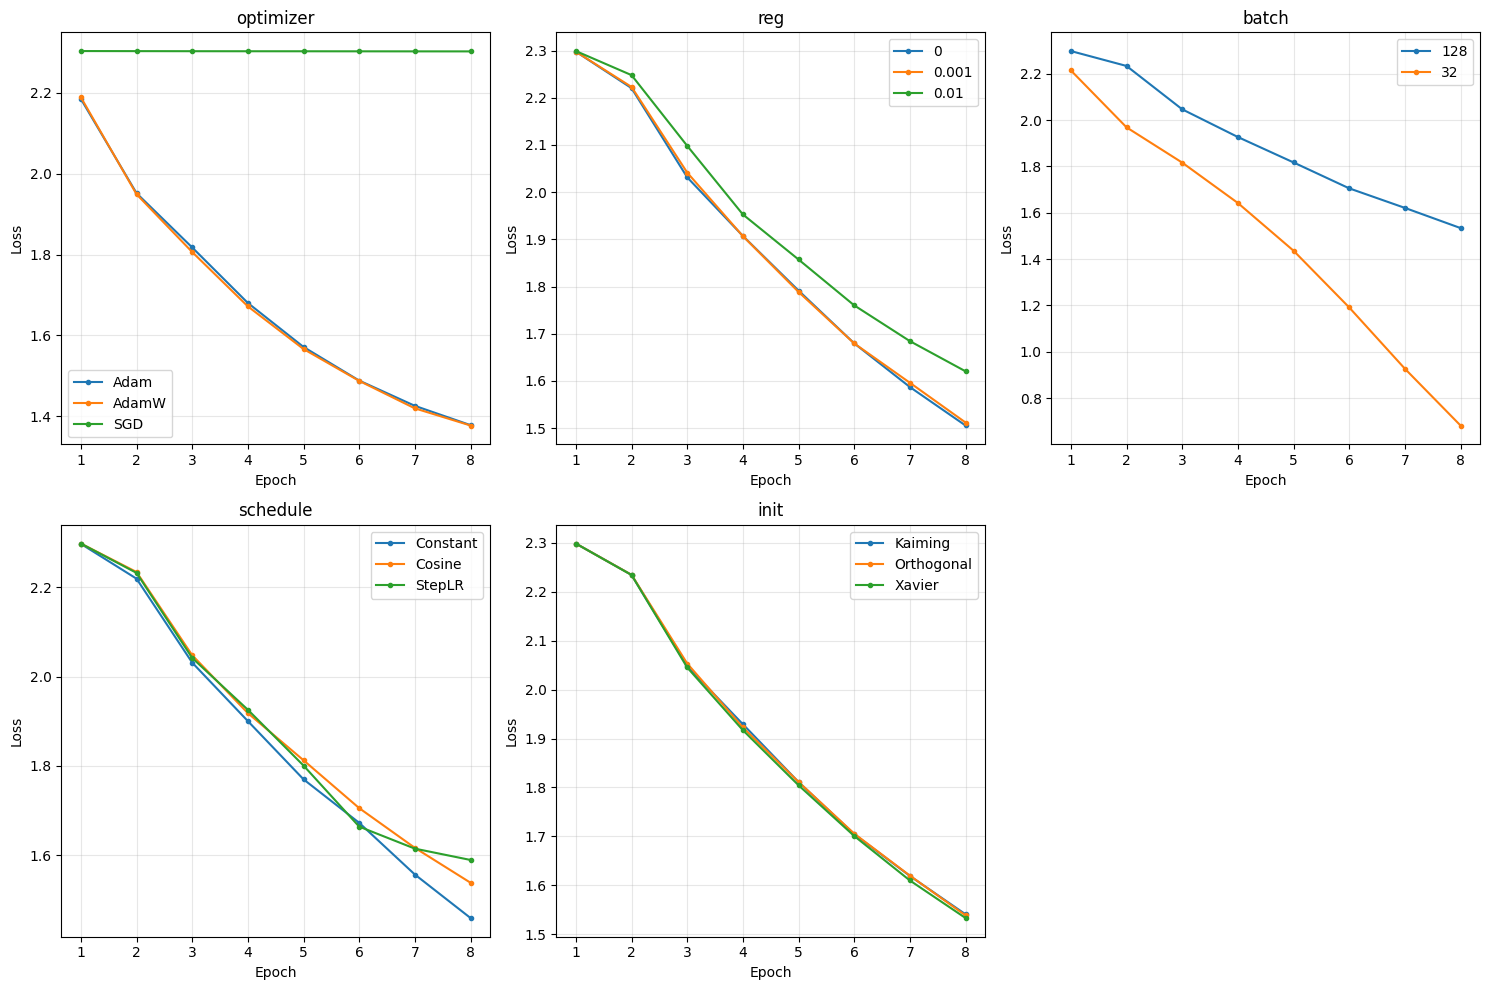

In [28]:
plot_training_curves(cnn_logs)